## Imports and read in data

!Note for this model due to limited access to HPC (the GPU queue was too long). I decided to only work on a subset of the samples. However, I have working code indicating how I would fine tune using parallel GPUs

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import os
from file_generate.filter_master import filter_master
import numpy as np
import torch

/arc/project/st-jiaruid-1/linshuan/conda/vector/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## DNABERT2 model exploration

### Load in the model

Check if internet access is available, if not load from local cache

In [ ]:
import os
hostname = "huggingface.co" #example
response = os.system("ping -c 1 " + hostname)

#and then check the response...
if response == 0:
	print(f"{hostname} is up!")
	tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", 
                                    trust_remote_code=True,force_download=False)
	model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", 
									trust_remote_code=True,force_download=False)
else:
	print(f"{hostname} is down!")
	tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True,force_download=False, local_files_only=True)
	model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True,force_download=False, local_files_only=True)

sh: 1: ping: Operation not permitted


huggingface.co is down!


/scratch/st-jiaruid-1/linshuan/.cache/hugginface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/25abaf0bd247444fcfa837109f12088114898d98/bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that 

### Replicate the results in the DNABERT2 modle
```{Bash}
export DATA_PATH=DHSs-Vector/data/GUE
export DATA_PATH=/path/to/GUE #(e.g., /home/user)
cd DNABERT_2/finetune
# Evaluate DNABERT-2 on GUE
sh scripts/run_dnabert2.sh DATA_PATH
```

## EDA

### Taking a look at the vocab metadata

In [ ]:
vocab_df = pd.read_table('data/DHS_Index_and_Vocabulary_hg38_WM20190703.txt')

/tmp/slurm/573480/ipykernel_202929/3896072397.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  vocab_df = pd.read_table('data/DHS_Index_and_Vocabulary_hg38_WM20190703.txt')


In [ ]:
vocab_df

,seqname,start,end,identifier,mean_signal,numsamples,summit,core_start,core_end,component
0,chr1,16140,16200,1.10011,0.129388,1,16170,16170.0,16170.0,Tissue invariant
1,chr1,51868,52040,1.10021,0.080034,1,51970,51970.0,51970.0,Placental / trophoblast
2,chr1,57280,57354,1.10025,0.273251,4,57350,57350.0,57350.0,Neural
3,chr1,66370,66482,1.10027,0.183716,8,66430,66410.0,66430.0,Primitive / embryonic
4,chr1,79100,79231,1.1003,0.113049,2,79150,79150.0,79150.0,Placental / trophoblast
...,...,...,...,...,...,...,...,...,...,...
3591893,chrY,56882540,56882719,Y.994281,0.038079,1,56882610,56882610.0,56882610.0,Lymphoid
3591894,chrY,56882864,56882980,Y.994286,0.115489,1,56882930,56882930.0,56882930.0,Lymphoid
3591895,chrY,56883733,56883960,Y.994292,0.491377,5,56883830,56883742.0,56883870.0,Placental / trophoblast
3591896,chrY,56884440,56884580,Y.994297,0.053759,1,56884510,56884510.0,56884510.0,Lymphoid


In [ ]:
print("unique components: ", len(vocab_df['component'].unique()))
print("components: ", vocab_df['component'].unique())


unique components:  16
components:  ['Tissue invariant' 'Placental / trophoblast' 'Neural'
 'Primitive / embryonic' 'Digestive' 'Lymphoid' 'Musculoskeletal'
 'Stromal B' 'Myeloid / erythroid' 'Cancer / epithelial'
 'Pulmonary devel.' 'Renal / cancer' 'Stromal A' 'Organ devel. / renal'
 'Vascular / endothelial' 'Cardiac']


In [ ]:
print("max num samples asspcoated with components: ", vocab_df['numsamples'].max())
print("average num samples assocaited with components: ", vocab_df['numsamples'].mean())


max num samples asspcoated with components:  733
average num samples assocaited with components:  21.235997514406034


#### Look at the width of the DHS region

In [ ]:
(vocab_df['end'] - vocab_df['start']).describe()

count    3.591898e+06
mean     2.039110e+02
std      1.028948e+02
min      2.000000e+01
25%      1.510000e+02
50%      1.960000e+02
75%      2.400000e+02
max      5.000000e+03
dtype: float64

#### Look at the confidence score

In [ ]:
vocab_df['mean_signal'].describe(exclude=['count'])

count    3.591898e+06
mean     6.401372e-01
std      9.392484e-01
min      1.228750e-02
25%      2.206620e-01
50%      4.103681e-01
75%      7.617222e-01
max      4.278597e+02
Name: mean_signal, dtype: float64

### Explore the vocab metadata

In [ ]:
meta_vocab = pd.read_table('data/DHS_Index_and_Vocabulary_metadata.tsv')
# loadings = np.load('data/2018-06-08NC16_NNDSVD_Basis.npy')

In [ ]:
meta_vocab

,library order,Biosample name,Vocabulary representative,DCC Experiment ID,DCC Library ID,DCC Biosample ID,DCC File ID,Altius Aggregation ID,Altius Library ID,Altius Biosample ID,...,Library cleanup,DNaseI units/mL,Amount Nucleic Acid (ng),Nuclei count,Protease inhibitor,Library sequencing date,Reads used,DCC SPOT score,Per-biosample peaks,DHSs in Index
0,1.0,GM06990,NaN,ENCSR000EMQ,ENCLB435ZZZ,ENCBS057ENC,ENCFF983CTQ,AG5636,LN1203,DS7748,...,Sucrose,NaN,50,NaN,NaN,2009-02-23,142681590.0,0.6790,83639.0,82918.0
1,2.0,HepG2,NaN,ENCSR000ENP,ENCLB480ZZZ,ENCBS114ENC,ENCFF419JVG,AG5635,LN1207,DS7764,...,Sucrose,NaN,50,NaN,NaN,2009-02-23,138826342.0,0.5858,89748.0,89235.0
2,3.0,hTH1,NaN,ENCSR000EQC,ENCLB591ZZZ,ENCBS345AAA,ENCFF575KOF,AG5634,LN1222,DS7840,...,Sucrose,6.0,534.9,NaN,NaN,2007-06-06,149158633.0,0.6470,94360.0,93665.0
3,4.0,Hela,NaN,ENCSR000ENO,ENCLB479ZZZ,ENCBS890POO,ENCFF503PAE,AG4219,LN1264,DS8200,...,new Sucrose,4.0,50,NaN,NaN,2007-08-24,23372724.0,0.6444,59098.0,59024.0
4,5.0,CACO2,NaN,ENCSR000EMI,ENCLB422ZZZ,ENCBS391ENC,ENCFF977BRD,AG4218,LN1269,DS8235,...,Sucrose,8.0,1,NaN,NaN,2007-09-05,22760059.0,0.7190,29894.0,29724.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,730.0,fBone_femur,Musculoskeletal,ENCSR805XIF,ENCLB236BWV,ENCBS337FPV,ENCFF604WIO,AG7442,LN45038B,DS36206B,...,NaN,NaN,8.8,1050000.0,A+Sucrose,2017-02-17,252066174.0,0.5823,146918.0,145356.0
730,731.0,fLiver,NaN,ENCSR562FNN,ENCLB638FEH,ENCBS275VNY,ENCFF795ZXN,AG7443,LN45070C,DS37372C,...,NaN,NaN,4.48,2140000.0,A+Sucrose,NaN,190541422.0,0.3703,76639.0,75369.0
731,732.0,fPlacenta,NaN,ENCSR552RKI,ENCLB423VBC,ENCBS565KNL,ENCFF084UVH,AG8805,LN45072C,DS37386C,...,NaN,NaN,1.325,1050000.0,A+Sucrose,NaN,203699532.0,0.3869,107611.0,106022.0
732,733.0,fPlacenta,Placental / trophoblast,ENCSR552XJI,ENCLB711ZZZ,ENCBS723HLT,ENCFF593AWN,AG7450,LN45076C,DS37716C,...,NaN,NaN,0.972,1380000.0,A+Sucrose,NaN,206456483.0,0.4356,115898.0,114344.0


### Now we look at the basis

In [ ]:
# loadings = pd.read_table('data/DHS_Index_and_Vocabulary_metadata.tsv', header=None)
loadings = pd.read_csv('data/2018-06-08NC16_NNDSVD_Basis.csv')

In [ ]:
vocab_df

,seqname,start,end,identifier,mean_signal,numsamples,summit,core_start,core_end,component
0,chr1,16140,16200,1.10011,0.129388,1,16170,16170.0,16170.0,Tissue invariant
1,chr1,51868,52040,1.10021,0.080034,1,51970,51970.0,51970.0,Placental / trophoblast
2,chr1,57280,57354,1.10025,0.273251,4,57350,57350.0,57350.0,Neural
3,chr1,66370,66482,1.10027,0.183716,8,66430,66410.0,66430.0,Primitive / embryonic
4,chr1,79100,79231,1.1003,0.113049,2,79150,79150.0,79150.0,Placental / trophoblast
...,...,...,...,...,...,...,...,...,...,...
3591893,chrY,56882540,56882719,Y.994281,0.038079,1,56882610,56882610.0,56882610.0,Lymphoid
3591894,chrY,56882864,56882980,Y.994286,0.115489,1,56882930,56882930.0,56882930.0,Lymphoid
3591895,chrY,56883733,56883960,Y.994292,0.491377,5,56883830,56883742.0,56883870.0,Placental / trophoblast
3591896,chrY,56884440,56884580,Y.994297,0.053759,1,56884510,56884510.0,56884510.0,Lymphoid


### Finally look at the peaks master_dataset produced

In [ ]:
peaks = pd.read_feather('data/master_dataset.ftr')

In [ ]:
peaks

,dhs_id,chr,start,end,DHS_width,summit,numsamples,total_signal,component,proportion,...,fKidney_ENCLB005SRL,fKidney_ENCLB704GMQ,fKidney_ENCLB759USM,fLung_ENCLB594BSZ,fKidney_ENCLB049MNH,fUmbilical_cord_ENCLB771UER,fBone_femur_ENCLB236BWV,fLiver_ENCLB638FEH,fPlacenta_ENCLB423VBC,fPlacenta_ENCLB711ZZZ
0,chr1_16140_16200_16170,chr1,16140,16200,60,16170,1,0.129388,1,0.855153,...,0,0,0,0,0,0,0,0,0,0
1,chr1_51868_52040_51970,chr1,51868,52040,172,51970,1,0.080034,7,0.973545,...,0,0,0,0,0,0,0,0,0,0
2,chr1_57280_57354_57350,chr1,57280,57354,74,57350,4,1.093002,8,1.000000,...,0,0,0,0,0,0,0,0,0,0
3,chr1_66370_66482_66430,chr1,66370,66482,112,66430,8,1.469725,3,0.332213,...,0,0,0,0,0,0,0,0,0,0
4,chr1_79100_79231_79150,chr1,79100,79231,131,79150,2,0.226098,7,0.501840,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3591893,chrY_56882540_56882719_56882610,chrY,56882540,56882719,179,56882610,1,0.038079,5,0.803229,...,0,0,0,0,0,0,0,0,0,0
3591894,chrY_56882864_56882980_56882930,chrY,56882864,56882980,116,56882930,1,0.115489,5,0.742349,...,0,0,0,0,0,0,0,0,0,0
3591895,chrY_56883733_56883960_56883830,chrY,56883733,56883960,227,56883830,5,2.456885,7,0.559734,...,0,0,0,0,0,0,0,0,0,0
3591896,chrY_56884440_56884580_56884510,chrY,56884440,56884580,140,56884510,1,0.053759,5,0.803229,...,0,0,0,0,0,0,0,0,0,0


## Data preprocessing

We want to first experiment on "easy" peaks (also because lack of computing power and no HPC). As such we will work on only a subset of samples as a proof of concept.
We argue that this is an "easier" problem for the model and it should probably work better

1. First work on top 75% peaks with the highest component proportion
2. Bio samples with vocabulary representative component (not the tissue invariant ones)
3. Look at Renal and epithelial cells specifically since they seem to have both disease and normal tissues
4. Randomly sampel only 20,000 DHS

In [ ]:
meta_vocab

,library order,Biosample name,Vocabulary representative,DCC Experiment ID,DCC Library ID,DCC Biosample ID,DCC File ID,Altius Aggregation ID,Altius Library ID,Altius Biosample ID,...,Library cleanup,DNaseI units/mL,Amount Nucleic Acid (ng),Nuclei count,Protease inhibitor,Library sequencing date,Reads used,DCC SPOT score,Per-biosample peaks,DHSs in Index
0,1.0,GM06990,NaN,ENCSR000EMQ,ENCLB435ZZZ,ENCBS057ENC,ENCFF983CTQ,AG5636,LN1203,DS7748,...,Sucrose,NaN,50,NaN,NaN,2009-02-23,142681590.0,0.6790,83639.0,82918.0
1,2.0,HepG2,NaN,ENCSR000ENP,ENCLB480ZZZ,ENCBS114ENC,ENCFF419JVG,AG5635,LN1207,DS7764,...,Sucrose,NaN,50,NaN,NaN,2009-02-23,138826342.0,0.5858,89748.0,89235.0
2,3.0,hTH1,NaN,ENCSR000EQC,ENCLB591ZZZ,ENCBS345AAA,ENCFF575KOF,AG5634,LN1222,DS7840,...,Sucrose,6.0,534.9,NaN,NaN,2007-06-06,149158633.0,0.6470,94360.0,93665.0
3,4.0,Hela,NaN,ENCSR000ENO,ENCLB479ZZZ,ENCBS890POO,ENCFF503PAE,AG4219,LN1264,DS8200,...,new Sucrose,4.0,50,NaN,NaN,2007-08-24,23372724.0,0.6444,59098.0,59024.0
4,5.0,CACO2,NaN,ENCSR000EMI,ENCLB422ZZZ,ENCBS391ENC,ENCFF977BRD,AG4218,LN1269,DS8235,...,Sucrose,8.0,1,NaN,NaN,2007-09-05,22760059.0,0.7190,29894.0,29724.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,730.0,fBone_femur,Musculoskeletal,ENCSR805XIF,ENCLB236BWV,ENCBS337FPV,ENCFF604WIO,AG7442,LN45038B,DS36206B,...,NaN,NaN,8.8,1050000.0,A+Sucrose,2017-02-17,252066174.0,0.5823,146918.0,145356.0
730,731.0,fLiver,NaN,ENCSR562FNN,ENCLB638FEH,ENCBS275VNY,ENCFF795ZXN,AG7443,LN45070C,DS37372C,...,NaN,NaN,4.48,2140000.0,A+Sucrose,NaN,190541422.0,0.3703,76639.0,75369.0
731,732.0,fPlacenta,NaN,ENCSR552RKI,ENCLB423VBC,ENCBS565KNL,ENCFF084UVH,AG8805,LN45072C,DS37386C,...,NaN,NaN,1.325,1050000.0,A+Sucrose,NaN,203699532.0,0.3869,107611.0,106022.0
732,733.0,fPlacenta,Placental / trophoblast,ENCSR552XJI,ENCLB711ZZZ,ENCBS723HLT,ENCFF593AWN,AG7450,LN45076C,DS37716C,...,NaN,NaN,0.972,1380000.0,A+Sucrose,NaN,206456483.0,0.4356,115898.0,114344.0


In [ ]:
# rep_lib = meta_vocab[(meta_vocab['Vocabulary representative'].notna()) & (meta_vocab['Vocabulary representative'] != "Tissue invariant") & ((meta_vocab['System'] == "Renal") | (meta_vocab['System'] == "Epithelial"))
#                      & (meta_vocab['DCC SPOT score'] > meta_vocab['DCC SPOT score'].describe()['50%'])]
rep_lib = meta_vocab[(meta_vocab['Vocabulary representative'].notna()) &  ((meta_vocab['System'] == "Renal") | (meta_vocab['System'] == "Epithelial"))
                     & (meta_vocab['DCC SPOT score'] > meta_vocab['DCC SPOT score'].describe()['50%'])]
rep_lib_id = rep_lib['Biosample name'] + "_" + rep_lib['DCC Library ID']

In [ ]:
peaks['proportion'].describe().loc['25%']

0.45994189828590715

In [ ]:
filtered_peaks = peaks[(peaks['proportion'] > 0.5) & (peaks[rep_lib_id.tolist()].any(axis=1)) & (peaks['chr'] !='chrX')]

In [ ]:
filtered_peaks['DHS_width'].describe()

count    418212.000000
mean        212.001294
std          89.757107
min          20.000000
25%         171.000000
50%         200.000000
75%         237.000000
max        2760.000000
Name: DHS_width, dtype: float64

### Check the most frequent components

In [ ]:
filtered_peaks['component'].value_counts()

component
10    92655
4     81952
6     58808
16    58700
3     45302
7     18725
8     14469
13     9348
5      6801
12     6250
14     5898
9      5629
15     5530
11     5265
1      1978
2       902
Name: count, dtype: int64

### Remove components that are not representative so far

In [ ]:
filtered_peaks = filtered_peaks[filtered_peaks['component'].isin(filtered_peaks['component'].value_counts().index[filtered_peaks['component'].value_counts() > 10000].tolist())]

In [ ]:
filtered_peaks['component'].value_counts()

component
10    92655
4     81952
6     58808
16    58700
3     45302
7     18725
8     14469
Name: count, dtype: int64

### Map components to {0 ... k} for classification

In [ ]:

mapping = {label: i for i, label in enumerate(sorted(set(filtered_peaks['component'].value_counts().index)))}
reverse_mapping = {new: original for original, new in mapping.items()}

In [ ]:
filtered_peaks['component'] = filtered_peaks['component'].map(mapping)

### Randomly sample

In [ ]:
filtered_peaks_sampled = filtered_peaks.sample(n=50000, replace=False, random_state=43)

### Store the data for fine-tuning

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(filtered_peaks_sampled[["sequence", "component"]], test_size=0.2, random_state=42, shuffle=True)
train, val = train_test_split(train, test_size=0.2, random_state=42,shuffle=True)

In [ ]:
train.to_csv("/scratch/st-jiaruid-1/linshuan/slurm/vector/data/train.csv", index=False)
val.to_csv("/scratch/st-jiaruid-1/linshuan/slurm/vector/data/dev.csv", index=False)
test.to_csv("/scratch/st-jiaruid-1/linshuan/slurm/vector/data/test.csv", index=False)

# train.to_csv("data/train.csv", index=False)
# val.to_csv("data/dev.csv", index=False)
# test.to_csv("data/test.csv", index=False)

**Run fine tune here**

In [ ]:
model = model.to('cuda')
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(4096, 768, padding_idx=0)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertUnpadAttention(
          (self): BertUnpadSelfAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (mlp): BertGatedLinearUnitMLP(
          (gated_layers): Linear(in_features=768, out_features=6144, bias=False)
          (act): GELU(approximate='none')
  

### Obtain embeddings from model

In [ ]:
tokens = tokenizer(filtered_peaks_sampled['sequence'].tolist(), padding=True, truncation=True, return_tensors="pt").to('cuda')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


### Utilizing garbarge collector to get around the problem of cuda out of memory

In [ ]:
import gc
stride = 500
embeddings_avg = None
start = 0
end = 0
with torch.no_grad():
	while end < tokens['input_ids'].shape[0]:
		end = min(end+stride, tokens['input_ids'].shape[0]+1)
		print("working on ", start, " to ", end)
		embeddings = model(tokens['input_ids'][start:end], tokens['attention_mask'][start:end])[0]
		if start == 0:
			embeddings_avg = torch.mean(embeddings, axis=1).to('cpu').detach()
		else:
			embeddings_avg = torch.cat((embeddings_avg, torch.mean(embeddings, axis=1).to('cpu').detach()), 0)
		start = end
		del embeddings
		torch.cuda.empty_cache() 
		gc.collect()  # call the garbage collector


working on  0  to  500
working on  500  to  1000
working on  1000  to  1500
working on  1500  to  2000
working on  2000  to  2500
working on  2500  to  3000
working on  3000  to  3500
working on  3500  to  4000
working on  4000  to  4500
working on  4500  to  5000
working on  5000  to  5500
working on  5500  to  6000
working on  6000  to  6500
working on  6500  to  7000
working on  7000  to  7500
working on  7500  to  8000
working on  8000  to  8500
working on  8500  to  9000
working on  9000  to  9500
working on  9500  to  10000
working on  10000  to  10500
working on  10500  to  11000
working on  11000  to  11500
working on  11500  to  12000
working on  12000  to  12500
working on  12500  to  13000
working on  13000  to  13500
working on  13500  to  14000
working on  14000  to  14500
working on  14500  to  15000
working on  15000  to  15500
working on  15500  to  16000
working on  16000  to  16500
working on  16500  to  17000
working on  17000  to  17500
working on  17500  to  18000


In [ ]:
embeddings_avg.shape

torch.Size([50000, 768])

### Visualize pooled embeddings of the model

<Axes: >

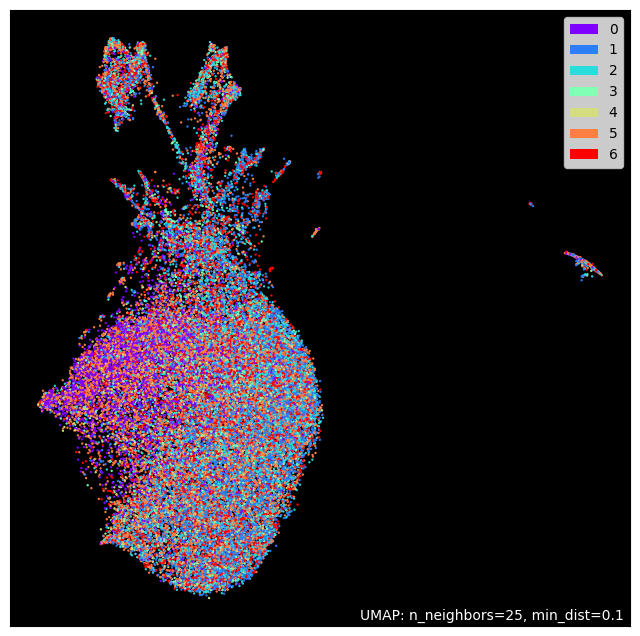

In [ ]:
import umap
import umap.plot
mapper = umap.UMAP(n_neighbors=25, min_dist=0.1, n_components=2).fit(embeddings_avg)
umap.plot.points(mapper, labels=filtered_peaks_sampled['component'], theme='fire')

### Try max pooling

In [ ]:
import gc
stride = 500
embeddings_max = None
start = 0
end = 0
with torch.no_grad():
	while end < tokens['input_ids'].shape[0]:
		end = min(end+stride, tokens['input_ids'].shape[0]+1)
		print("working on ", start, " to ", end)
		embeddings = model(tokens['input_ids'][start:end], tokens['attention_mask'][start:end])[0]
		if start == 0:
			embeddings_max = torch.max(embeddings, axis=1)[0].to('cpu').detach()
		else:
			embeddings_max = torch.cat((embeddings_max, torch.max(embeddings, axis=1)[0].to('cpu').detach()), 0)
		start = end
		del embeddings
		torch.cuda.empty_cache() 
		gc.collect()  # call the garbage collector

working on  0  to  500


working on  500  to  1000
working on  1000  to  1500
working on  1500  to  2000
working on  2000  to  2500
working on  2500  to  3000
working on  3000  to  3500
working on  3500  to  4000
working on  4000  to  4500
working on  4500  to  5000
working on  5000  to  5500
working on  5500  to  6000
working on  6000  to  6500
working on  6500  to  7000
working on  7000  to  7500
working on  7500  to  8000
working on  8000  to  8500
working on  8500  to  9000
working on  9000  to  9500
working on  9500  to  10000
working on  10000  to  10500
working on  10500  to  11000
working on  11000  to  11500
working on  11500  to  12000
working on  12000  to  12500
working on  12500  to  13000
working on  13000  to  13500
working on  13500  to  14000
working on  14000  to  14500
working on  14500  to  15000
working on  15000  to  15500
working on  15500  to  16000
working on  16000  to  16500
working on  16500  to  17000
working on  17000  to  17500
working on  17500  to  18000
working on  18000  to  

<Axes: >

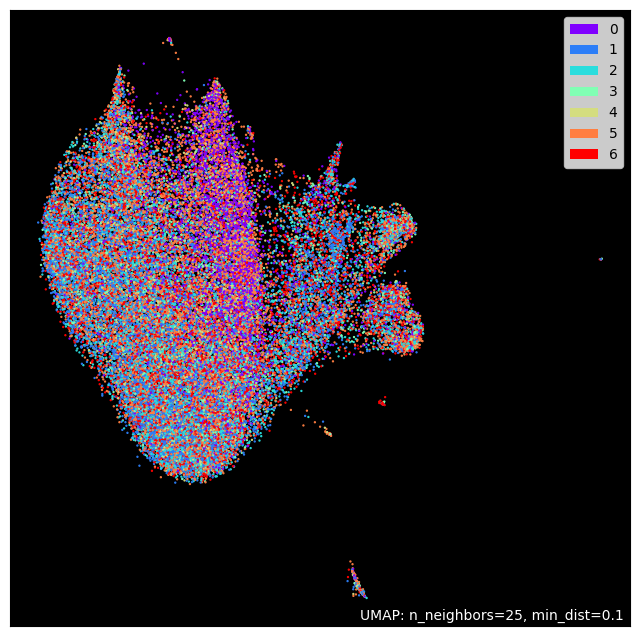

In [ ]:
import umap
import umap.plot
mapper = umap.UMAP(n_neighbors=25, min_dist=0.1, n_components=2).fit(embeddings_max)
umap.plot.points(mapper, labels=filtered_peaks_sampled['component'], theme='fire')

### It would seem that the pre-trained bert model is under utlizing the latent space given our specific tasks

In [ ]:
from sklearn.linear_model import LogisticRegression
train_x, val_x = train_test_split(embeddings_avg, test_size=0.2, random_state=42, shuffle=True)
train_y, val_y = train_test_split(filtered_peaks_sampled['component'], test_size=0.2, random_state=42, shuffle=True)
lr = LogisticRegression( random_state=42, multi_class="multinomial")

lr.fit(train_x.numpy(), train_y)
lr.score(val_x.numpy(), val_y)

/arc/project/st-jiaruid-1/linshuan/conda/vector/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.3759

## Pre trained model
**Pre-trained using code in util folder**

### Fine tune results for accuracy
![assets/Eval_accuracy.png](assets/Eval_accuracy.png)

### Fine tune results for f1
![assets/Eval_accuracy.png](assets/F1_pre_train.png)

### Load in the models

In [ ]:
import wandb
api = wandb.Api()
os.chdir("/scratch/st-jiaruid-1/linshuan/slurm/vector")
artifact = api.artifact('ding-group/DNABERT/model-parallel:v0', type='model')
artifact_dir = artifact.download()
model = AutoModel.from_pretrained(artifact_dir, trust_remote_code=True,force_download=False, local_files_only=True).to('cuda')


wandb: Downloading large artifact model-parallel:v0, 446.81MB. 6 files... 
wandb:   6 of 6 files downloaded.  
Done. 0:0:1.1
/scratch/st-jiaruid-1/linshuan/.cache/hugginface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/25abaf0bd247444fcfa837109f12088114898d98/bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at /scratch/st-jiaruid-1/linshuan/slurm/vector/artifacts/model-parallel:v0 were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly id

### Check latent space with pre-trained model

In [47]:
import gc
stride = 1000
embeddings_avg = None
start = 0
end = 0
with torch.no_grad():
	while end < tokens['input_ids'].shape[0]:
		end = min(end+stride, tokens['input_ids'].shape[0]+1)
		print("working on ", start, " to ", end)
		embeddings = model(tokens['input_ids'][start:end], tokens['attention_mask'][start:end])[0]
		if start == 0:
			embeddings_avg = torch.mean(embeddings, axis=1).to('cpu').detach()
		else:
			embeddings_avg = torch.cat((embeddings_avg, torch.mean(embeddings, axis=1).to('cpu').detach()), 0)
		start = end
		del embeddings
		torch.cuda.empty_cache() 
		gc.collect()  # call the garbage collector


working on  0  to  1000
working on  1000  to  2000
working on  2000  to  3000
working on  3000  to  4000
working on  4000  to  5000
working on  5000  to  6000
working on  6000  to  7000
working on  7000  to  8000
working on  8000  to  9000
working on  9000  to  10000
working on  10000  to  11000
working on  11000  to  12000
working on  12000  to  13000
working on  13000  to  14000
working on  14000  to  15000
working on  15000  to  16000
working on  16000  to  17000
working on  17000  to  18000
working on  18000  to  19000
working on  19000  to  20000
working on  20000  to  21000
working on  21000  to  22000
working on  22000  to  23000
working on  23000  to  24000
working on  24000  to  25000
working on  25000  to  26000
working on  26000  to  27000
working on  27000  to  28000
working on  28000  to  29000
working on  29000  to  30000
working on  30000  to  31000
working on  31000  to  32000
working on  32000  to  33000
working on  33000  to  34000
working on  34000  to  35000
working

In [48]:
embeddings_avg.shape

torch.Size([50000, 768])

### Visualize pooled embeddings of the model

<Axes: >

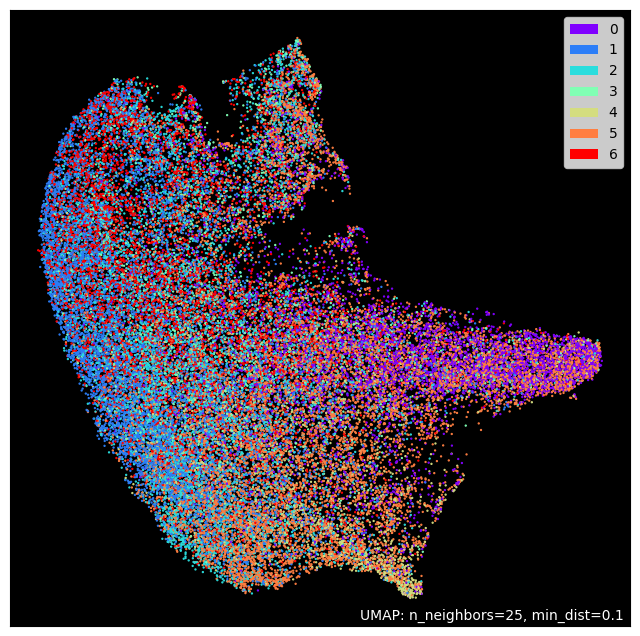

In [49]:
import umap
import umap.plot
mapper = umap.UMAP(n_neighbors=25, min_dist=0.1, n_components=2).fit(embeddings_avg)
umap.plot.points(mapper, labels=filtered_peaks_sampled['component'], theme='fire')

### Try max pooling

In [51]:
import gc
stride = 1000
embeddings_max = None
start = 0
end = 0
with torch.no_grad():
	while end < tokens['input_ids'].shape[0]:
		end = min(end+stride, tokens['input_ids'].shape[0]+1)
		print("working on ", start, " to ", end)
		embeddings = model(tokens['input_ids'][start:end], tokens['attention_mask'][start:end])[0]
		if start == 0:
			embeddings_max = torch.max(embeddings, axis=1)[0].to('cpu').detach()
		else:
			embeddings_max = torch.cat((embeddings_max, torch.max(embeddings, axis=1)[0].to('cpu').detach()), 0)
		start = end
		del embeddings
		torch.cuda.empty_cache() 
		gc.collect()  # call the garbage collector

working on  0  to  1000
working on  1000  to  2000
working on  2000  to  3000
working on  3000  to  4000
working on  4000  to  5000
working on  5000  to  6000
working on  6000  to  7000
working on  7000  to  8000
working on  8000  to  9000
working on  9000  to  10000
working on  10000  to  11000
working on  11000  to  12000
working on  12000  to  13000
working on  13000  to  14000
working on  14000  to  15000
working on  15000  to  16000
working on  16000  to  17000
working on  17000  to  18000
working on  18000  to  19000
working on  19000  to  20000
working on  20000  to  21000
working on  21000  to  22000
working on  22000  to  23000
working on  23000  to  24000
working on  24000  to  25000
working on  25000  to  26000
working on  26000  to  27000
working on  27000  to  28000
working on  28000  to  29000
working on  29000  to  30000
working on  30000  to  31000
working on  31000  to  32000
working on  32000  to  33000
working on  33000  to  34000
working on  34000  to  35000
working

<Axes: >

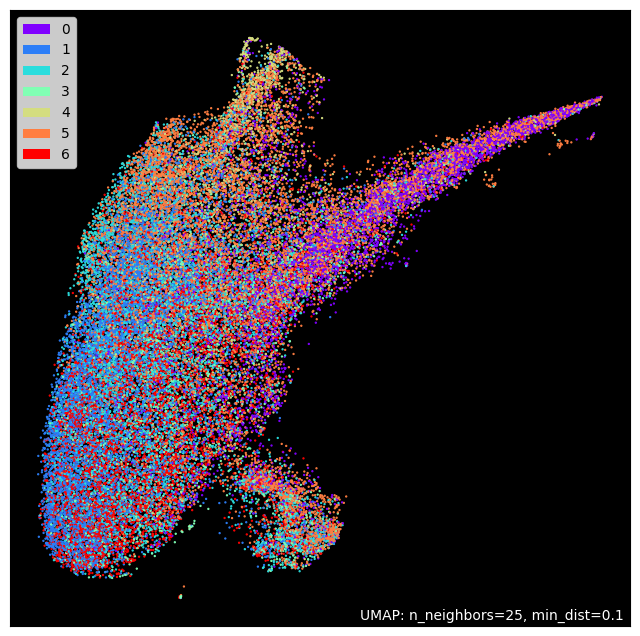

In [52]:
import umap
import umap.plot
mapper = umap.UMAP(n_neighbors=25, min_dist=0.1, n_components=2).fit(embeddings_max)
umap.plot.points(mapper, labels=filtered_peaks_sampled['component'], theme='fire')

### Tried transfer learning again
The result is much better and can probably be better with more data

In [53]:
from sklearn.linear_model import LogisticRegression
train_x, val_x = train_test_split(embeddings_avg, test_size=0.2, random_state=42, shuffle=True)
train_y, val_y = train_test_split(filtered_peaks_sampled['component'], test_size=0.2, random_state=42, shuffle=True)
lr = LogisticRegression( random_state=42, multi_class="multinomial")

lr.fit(train_x.numpy(), train_y)
lr.score(val_x.numpy(), val_y)

/arc/project/st-jiaruid-1/linshuan/conda/vector/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.469

### Now separate the cells into disease and non disease



In [75]:
rep_lib_normal = meta_vocab[(meta_vocab['Biological state']=="Primary")]
rep_lib_disease = meta_vocab[(meta_vocab['Biological state']=="Cancer")]

rep_lib_normal = rep_lib_normal['Biosample name'] + "_" + rep_lib_normal['DCC Library ID']
rep_lib_disease = rep_lib_disease['Biosample name'] + "_" + rep_lib_disease['DCC Library ID']

In [106]:
exclusive = filter_master(filtered_peaks, list(set(rep_lib_normal.unique().tolist() + rep_lib_disease.unique().tolist())),)

Filtering exclusive peaks between replicates


/arc/project/st-jiaruid-1/linshuan/DHSs-Vector/file_generate/filter_master.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['TAG'] = df_subset[self.cell_list].apply(lambda x: 'NO_TAG' if x.sum() != 1 else x.idxmax(), axis=1)


Cell type: Caki2, Replicate: ENCLB384WEU, Number of exclusive peaks: 3686
Cell type: HCPEpiC, Replicate: ENCLB472ZZZ, Number of exclusive peaks: 2041
Cell type: HEEpiC, Replicate: ENCLB476ZZZ, Number of exclusive peaks: 3230
Cell type: HEEpiC, Replicate: ENCLB477ZZZ, Number of exclusive peaks: 36
Cell type: HIPEpiC, Replicate: ENCLB488ZZZ, Number of exclusive peaks: 1119
Cell type: HRCE, Replicate: ENCLB522ZZZ, Number of exclusive peaks: 4169
Cell type: MCF10a_ER_SRC_24h_Tam, Replicate: ENCLB997DNA, Number of exclusive peaks: 3258
Cell type: MCF10a_ER_SRC_6h_Tam/Washout 18 h, Replicate: ENCLB662JJO, Number of exclusive peaks: 318
Cell type: MCF10a_ER_SRC_control, Replicate: ENCLB086WLE, Number of exclusive peaks: 829
Cell type: fKidney, Replicate: ENCLB005SRL, Number of exclusive peaks: 16721
Cell type: fKidney, Replicate: ENCLB049MNH, Number of exclusive peaks: 1205
Cell type: fKidney, Replicate: ENCLB334GBK, Number of exclusive peaks: 2449
Cell type: fKidney, Replicate: ENCLB476KOD, 

In [107]:
tokens = tokenizer(exclusive['sequence'].tolist(), padding=True, truncation=True, return_tensors="pt").to('cuda')

In [108]:
import gc
stride = 1000
embeddings_avg_ex = None
start = 0
end = 0
with torch.no_grad():
	while end < tokens['input_ids'].shape[0]:
		end = min(end+stride, tokens['input_ids'].shape[0]+1)
		print("working on ", start, " to ", end)
		embeddings = model(tokens['input_ids'][start:end], tokens['attention_mask'][start:end])[0]
		if start == 0:
			embeddings_avg_ex = torch.mean(embeddings, axis=1).to('cpu').detach()
		else:
			embeddings_avg_ex = torch.cat((embeddings_avg_ex, torch.mean(embeddings, axis=1).to('cpu').detach()), 0)
		start = end
		del embeddings
		torch.cuda.empty_cache() 
		gc.collect()  # call the garbage collector


working on  0  to  676


In [109]:
exclusive

,dhs_id,chr,start,end,DHS_width,summit,numsamples,total_signal,component,proportion,...,fMuscle_back_ENCLB623IJC,fHeart_ENCLB491BID,hTH1_ENCLB591ZZZ,HUVEC_ENCLB533ZZZ,HMVEC_dBlNeo_ENCLB500ZZZ,SKNSH_ENCLB586ZZZ,HCF_ENCLB464ZZZ,TAG,additional_replicates_with_peak,other_samples_with_peak_not_considering_reps
1719,chr1_1472033_1472080_1472034,chr1,1472033,1472080,47,1472034,1,0.282251,2,0.876798,...,0,0,0,0,0,0,0,Caki2_ENCLB384WEU,0,0
1991,chr1_1616064_1616200_1616092,chr1,1616064,1616200,136,1616092,2,1.607042,2,0.751143,...,0,0,0,0,0,0,0,Caki2_ENCLB384WEU,0,1
2244,chr1_1759480_1759536_1759530,chr1,1759480,1759536,56,1759530,1,0.222099,2,0.876798,...,0,0,0,0,0,0,0,Caki2_ENCLB384WEU,0,0
5564,chr1_3381096_3381175_3381130,chr1,3381096,3381175,79,3381130,1,0.226726,2,0.876798,...,0,0,0,0,0,0,0,Caki2_ENCLB384WEU,0,0
7408,chr1_4425720_4425783_4425770,chr1,4425720,4425783,63,4425770,1,0.115677,2,0.876798,...,0,0,0,0,0,0,0,Caki2_ENCLB384WEU,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59261,chr1_34657869_34657980_34657910,chr1,34657869,34657980,111,34657910,1,0.067170,6,1.000000,...,0,0,0,0,0,0,0,vHMEC_ENCLB160GNU,0,0
64107,chr1_37745520_37745800_37745670,chr1,37745520,37745800,280,37745670,2,0.527488,6,0.563686,...,0,0,0,0,0,0,0,vHMEC_ENCLB160GNU,0,1
71329,chr1_42014856_42015024_42014930,chr1,42014856,42015024,168,42014930,2,0.612297,6,0.514720,...,0,0,0,0,0,0,0,vHMEC_ENCLB160GNU,0,1
72278,chr1_42762620_42762860_42762730,chr1,42762620,42762860,240,42762730,1,0.436604,6,1.000000,...,0,0,0,0,0,0,0,vHMEC_ENCLB160GNU,0,0


In [110]:
meta_vocab['Biological state']

0      Immortalized
1            Cancer
2           Primary
3            Cancer
4            Cancer
           ...     
729         Primary
730         Primary
731         Primary
732         Primary
733             NaN
Name: Biological state, Length: 734, dtype: object

In [111]:
exclusive['TAG'].value_counts()

TAG
Caki2_ENCLB384WEU                                25
HCPEpiC_ENCLB472ZZZ                              25
HEEpiC_ENCLB476ZZZ                               25
HEEpiC_ENCLB477ZZZ                               25
HIPEpiC_ENCLB488ZZZ                              25
HRCE_ENCLB522ZZZ                                 25
MCF10a_ER_SRC_24h_Tam_ENCLB997DNA                25
MCF10a_ER_SRC_6h_Tam/Washout 18 h_ENCLB662JJO    25
MCF10a_ER_SRC_control_ENCLB086WLE                25
fKidney_ENCLB005SRL                              25
fKidney_ENCLB049MNH                              25
fKidney_ENCLB334GBK                              25
fKidney_ENCLB476KOD                              25
fKidney_ENCLB704GMQ                              25
fKidney_ENCLB758OYY                              25
fKidney_ENCLB759USM                              25
fKidney_ENCLB896SWH                              25
fKidney_L_ENCLB423VBH                            25
fKidney_L_ENCLB759WWN                            25
fKidney_

In [112]:
label = exclusive['TAG'].map(lambda tag: meta_vocab[meta_vocab['DCC Library ID'] == re.search(r'ENCL.*', tag)[0]]['Biosample type'].iloc[0])

In [113]:
label

1719      Cancer
1991      Cancer
2244      Cancer
5564      Cancer
7408      Cancer
          ...   
59261    Primary
64107    Primary
71329    Primary
72278    Primary
75654    Primary
Name: TAG, Length: 675, dtype: object

## Transfer learning on healthy/disease 

We were able to predict if a DHS is going to be from a cancer or primary tissue with 0.72 accuracy

In [123]:
from sklearn.linear_model import LogisticRegression
train_x, val_x = train_test_split(embeddings_avg_ex, test_size=0.2, random_state=42, shuffle=True)
train_y, val_y = train_test_split(label, test_size=0.2, random_state=42, shuffle=True)
lr = LogisticRegression( random_state=42)

lr.fit(train_x.numpy(), train_y)
lr.score(val_x.numpy(), val_y)

0.7185185185185186